___
# Predictive Power - Interest rates versus GDP Growth
___

### TOC
- [Intro](#intro)
- [Method](#method)

The concensus across all schools of economics on this subject is that changes in interest rates lead to changes in GDP Growth. Given the physics-envy hued paradigm upon which economic thought and activity is based, this makes perfect sense; the more expensive money is, the less of it is bought and vice verca. In particular, monetary policy is the big societal application of this idea. While it makes perfect valid sense in the paradigm, there is reason to doubt that this idea is actually sound. For example (skip the code):

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

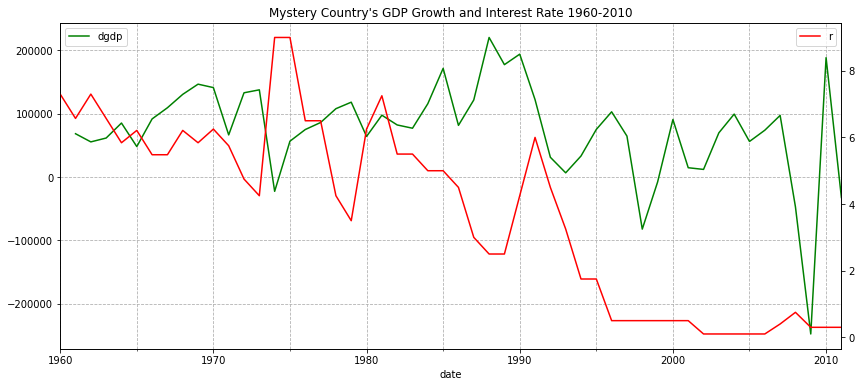

In [2]:
# --- Grab gdp and interest rates

path = "data/r_gdp_jp/"
start_date = dt.datetime.strptime("1960-01-01", "%Y-%m-%d")

gdp = pd.read_csv(path + "raw/gdp_jp_raw.csv").rename(
    columns={"DATE" : "date", "JPNRGDPR" : "gdp"}
)
jp_r = pd.read_csv(path + "raw/interest_jp_raw.csv").rename(
    columns={"DATE":"date","INTDSRJPM193N":"r"}
)
gdp.date = pd.to_datetime(gdp.date)
jp_r.date = pd.to_datetime(jp_r.date)
jp_r= jp_r.loc[jp_r.date.isin(gdp.date.values)]
jp_r = jp_r.loc[jp_r.date >= start_date].set_index("date")
gdp = gdp.set_index("date")
eg_1 = pd.concat([gdp, jp_r], axis=1)

# --- Calculate GDP growth

eg_1["dgdp"] = eg_1.gdp - eg_1.gdp.shift(1)

# --- Plot

_, ax1 = plt.subplots(1, figsize=(14, 6))
ax2 = ax1.twinx()
eg_1.plot(y="dgdp", c="g", ax=ax1);
eg_1.plot(y="r", c="r", ax=ax2);
ax1.legend(loc="upper left");
ax1.grid(which="major", linestyle="--")
ax1.grid(which="minor", linestyle="--")
ax1.set(title="Mystery Country's GDP Growth and Interest Rate 1960-2010");

___
## Intro <a id="intro"></a>
___
Assuming you didn't read the code, this mystery country's nominal GDP growth (in green) and interest rate (red) appears to be a counter example to the idea. There are parts of this plot that appear to be in line with the theory, for example, falling $r$ from 1960 until before that spike in 1973ish, accelerating ($\delta$GDP is already a rate of change) GDP growth coincides with declining $r$, and then the spike that follows directly after coincides with a large decelerating impulse in GDP growth. It all more or less looks fine until just before 1990 where things stop working pretty much completely. For an idea that is taken as so naturally self evident at face value, that's at least a little weird. This is, of course, the infamous macroeconomic mystery of Japanese nominal GDP growth and interest rate.

[The paper by Richard Werner](https://www.sciencedirect.com/science/article/pii/S0921800916307510) which inspired me to attempt this exercise in analysis and gesticulation, goes into more examples at greater depth so I won't spend too much time here, but I did want to raise a quote in the paper to our attention:

> As an empirical matter, low interest rates are a sign that monetary policy has been tight - in the sense that the quantity of money has grown slowly; high interest rates are a sign that monetary policy has been easy - in the sense that the quantity of money has grown rapidly. The broadest facts of experience run in precisely the opposite direction from that which the financial community and acedemic economists have all generally taken for granted.
>
> – Milton Friedman, 1968

#### Predictive Power, Causality, more Gesticulation
I want to see if my fast-and-loose approach can capture some of what this empirical study more rigorously has. What would constitute a success herein would be if I can show with my primitive sticks and stones and limited knowledge of statistics that one could be suspicious of the hypothesis that interest rates determine GDP growth. In particular, I'm quite curious about predictive power - whether or not [PPS](https://8080labs.com/blog/posts/rip-correlation-introducing-the-predictive-power-score-pps/) out of the box has something to say either in favour of or agaisnt the null hypothesis, $H_0$, and i'm also interested in trying my hand at [Granger causality](https://en.wikipedia.org/wiki/Granger_causality). These two things could work syngergistically and It's also something I want to apply across to my health data as well.

In the study, a few countries are analysed - Germany, Japan, United Kingdom, United States, and it is found that all but Germany comfortably destroy the $H_0$. In the case of Germay, it is only shaken violently off it's pedestol of hot air. Since the questions in question are with regards to the journey and the start and end points are part of the assumptions, whatever I yield on Germany, given that I take it on assumption to be diffferent, should be an interesting point of reference.

Werner does a bunch of other tests to counter some of the technical blindspots of the particular test. While this is a great idea for determining the facts in the first place, that isn't my goal. I will not be runing a bootstrap simulation to confirm significance without the issue of the F-stat's "non-standard asymptotic distribution" getting in the way as I have no idea what that means or why it's important. Clearly it's important enough that he does the work of implementing a suite of other tests, but that's at least two levels beyond my current knowledge. In the case that it is important, I'll find out.

## Riff off his Method <a id="method"></a>

I'm going to roughly copy his method but modify bits and pieces to see if I can fill in the gaps I create. Thus, for German, Japanese and American (why not) data, I need to traverse the following path of thinking:

The two series are either correlated or not. Since one would expect uncorrelated series to not have much to do with each other, we would like to establish correlation first, establish that they are co-related. Next, we need to establish causality. Co-relation could be co-incidence. Causality in timeseries strike me as a very perculiar subject, but I think we can just ballpark the intuition as something like: real event, $a$ causes a change in timeseries $a$ which is also it's ontological manifestation. Real event $a$ also causes a second real event, $b$ which is ontologically registered in timeseries $b$. So for a set of timeseries, causality is time ordering the events then establishing confidence that, without forgetting temporality, $a \implies b$ but also that $\lnot b \implies \lnot a$... to some degree. In english, what we want is 1. every time $a$ happens/appears, we'll see an occurrence of $b$, but also, that 2. the absense of $b$ means there wasn't $a$. To make intuitive sense of that second part, if $b$ was to regularly occurr without $a$ having happened, then we wouldn't be quite as confident that it is $a$ which is making $b$ happen.

There's still holes logically speaking; $a$ could still have explanatory power regarding $b$ without being the only factor, just to name one. However I only have so much time, and so to gesture generally in the direction of theory as vague justification, this level of logical rigour is probably good enough.

So, 

1. Grab correlations between GDP growth against interest rates and 10yr bond yields with lags
2. Repeat the two above steps but with PPS
3. Do a granger causality and contextualise the relevant statistics

In [4]:
### --- Grab Data

countries = ['de', 'jp', 'us']
dates = {}
bonds_dfs = {}
rates_dfs = {}
gdp_dfs = {}

for c in countries:
    bonds = pd.read_csv(path + "clean/10yr_bond_yields_{}.csv".format(c))[["date", "price"]]
    bonds["date"] = pd.to_datetime(bonds["date"])
    bonds = bonds.sort_values(by="date")
    dates['min'] = bonds.date.min()
    dates['max'] = bonds.date.max()
    bonds = bonds.set_index("date")
    bonds_dfs[c] = bonds
    
    rates = pd.read_csv(path + "clean/interest_{}.csv".format(c))
    rates['date'] = pd.to_datetime(rates['date'])
    rates = rates.set_index("date")
    rates_dfs[c] = rates
    
    gdp = pd.read_csv(path+ "clean/gdp_{}.csv".format(c))
    gdp['date'] = pd.to_datetime(gdp['date'])
    gdp = gdp.set_index("date")
    gdp_dfs[c] = gdp

df = pd.DataFrame(index=pd.date_range(start="1970-01-01", end="2021-01-01", freq="MS"))


for c in countries:
    df["{}_y".format(c)] = bonds_dfs[c]["price"]
    df["{}_r".format(c)] = rates_dfs[c]["interest_rate"]
    df["{}_g".format(c)] = gdp_dfs[c]["gdp"]

In [5]:
display(df.head())
df.info()
for i, dfs in {"rates": rates_dfs, "bonds": bonds_dfs, "gdp":gdp_dfs}.items():
    for c, d in dfs.items():
        print("\n{c} {i} min: {mn}\n{c} {i} max: {mx}".format(c=c, i=i,
                                                                  mx=d.index.max(), 
                                                                  mn=d.index.min())
             )

,de_y,de_r,de_g,jp_y,jp_r,jp_g,us_y,us_r,us_g
1970-01-01,NaN,9.0,NaN,NaN,6.25,1510249.0,NaN,6.0,1051.200
1970-02-01,7.8,9.0,NaN,NaN,6.25,NaN,7.24,6.0,NaN
1970-03-01,8.1,9.5,NaN,NaN,6.25,NaN,7.07,6.0,NaN
1970-04-01,8.1,9.5,NaN,NaN,6.25,NaN,7.39,6.0,1067.375
1970-05-01,8.4,9.5,NaN,NaN,6.25,NaN,7.91,6.0,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 613 entries, 1970-01-01 to 2021-01-01
Freq: MS
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   de_y    610 non-null    float64
 1   de_r    348 non-null    float64
 2   de_g    121 non-null    float64
 3   jp_y    423 non-null    float64
 4   jp_r    568 non-null    float64
 5   jp_g    42 non-null     float64
 6   us_y    612 non-null    float64
 7   us_r    613 non-null    float64
 8   us_g    205 non-null    float64
dtypes: float64(9)
memory usage: 47.9 KB

de rates min: 1950-01-01 00:00:00
de rates max: 1998-12-01 00:00:00

jp rates min: 1953-01-01 00:00:00
jp rates max: 2017-04-01 00:00:00

us rates min: 1950-01-01 00:00:00
us rates max: 2021-03-01 00:00:00

de bonds min: 1970-02-01 00:00:00
de bonds max: 2021-01-01 00:00:00

jp bonds min: 1985-11-01 00:00:00
jp bonds max: 2021-01-01 00:00:00

us bonds min: 1970-02-01 00:00:00
us bonds max: 2021-01-01 00:00:00

de gd

Due to sourcing downloadable data being really annoying and difficult, some of the data is not at the same frequency as the rest of it and the date ranges of each varies quite a lot. It's more than enough to draw conclusions, but just bringing it to your awareness now that the date manipulation will be all over the place.

### 1. GDP Growth Against 10-year Yields

#### 1.1 Japanese 10y Bond Yields against Japanese Interest Rates
- starting date
    - 1985-11-01
- ending date
    - 2017-04-01
    
#### 1.1 German 10y Bond Yields against German Interest Rates

- starting date
    - 1970-02-01
- ending date
    - 1998-12-01

#### 1.1 American 10y Bond Yields against American Interest Rates

- starting date
    - 1970-02-01
- ending date
    - 2021-01-01

In [102]:
# --- Take note of how .shift(lag) works

note = pd.DataFrame()
note["original de_r"] = df.de_r
note["shift by 1 de_r"] = note["original de_r"].shift(1).head()
note["shift by -1 de_r"] = note["original de_r"].shift(-1).head()
note.head()

,original de_r,shift by 1 de_r,shift by -1 de_r
1970-01-01,9.0,NaN,9.0
1970-02-01,9.0,9.0,9.5
1970-03-01,9.5,9.0,9.5
1970-04-01,9.5,9.5,9.5
1970-05-01,9.5,9.5,9.5


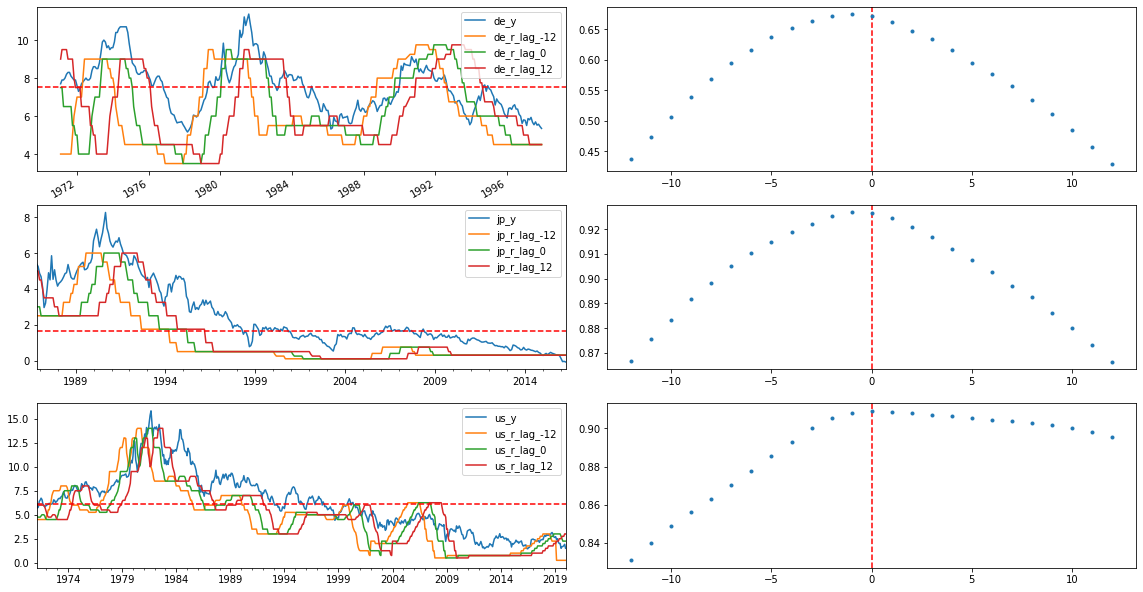

In [194]:
_, ax = plt.subplots(3, 2, figsize=(16, 10))
_.tight_layout(h_pad=2)

for i, c in enumerate(countries):
    
    df1 = df[["{}_r".format(c), "{}_y".format(c)]].dropna()
    deltas = range(-12, 13)

    for d in deltas:
        df1["{c}_r_lag_{d}".format(c=c, d=d)] = df1["{}_r".format(c)].shift(d)

    df1 = df1.dropna().drop("{}_r".format(c), axis=1)
    df1.plot(y=["{}_y".format(c),"{}_r_lag_-12".format(c), 
                "{}_r_lag_0".format(c), 
                "{}_r_lag_12".format(c)
               ], ax=ax[i,0]
            );
    correlations = df1.corr()["{}_y".format(c)].loc[df1.corr()["{}_y".format(c)] < 1]
    ax[i, 0].axhline(y=df1["{}_y".format(c)].median(), color="r", linestyle="--")
    ax[i, 1].axvline(x=0, color="r", linestyle="--")
    ax[i, 1].plot(deltas, correlations, '.');

For Germany and Japan there's a clear bias to the left (Vertical red line at zero). Since the rates are being lagged, this can be interpreted as bringing the interest rates back in time - yield preceed rates. America's plot is quite interesting. It seems that the lags which bring the rates forward in time are quite well correlated with the bond yields. That is to say, rates brought forward in time (rates preceed yields) do appear to have pretty decent correlations here, but to those familiar with regressions regarding cumulative rainfall, that particular undertone of petrichor is perceptible.

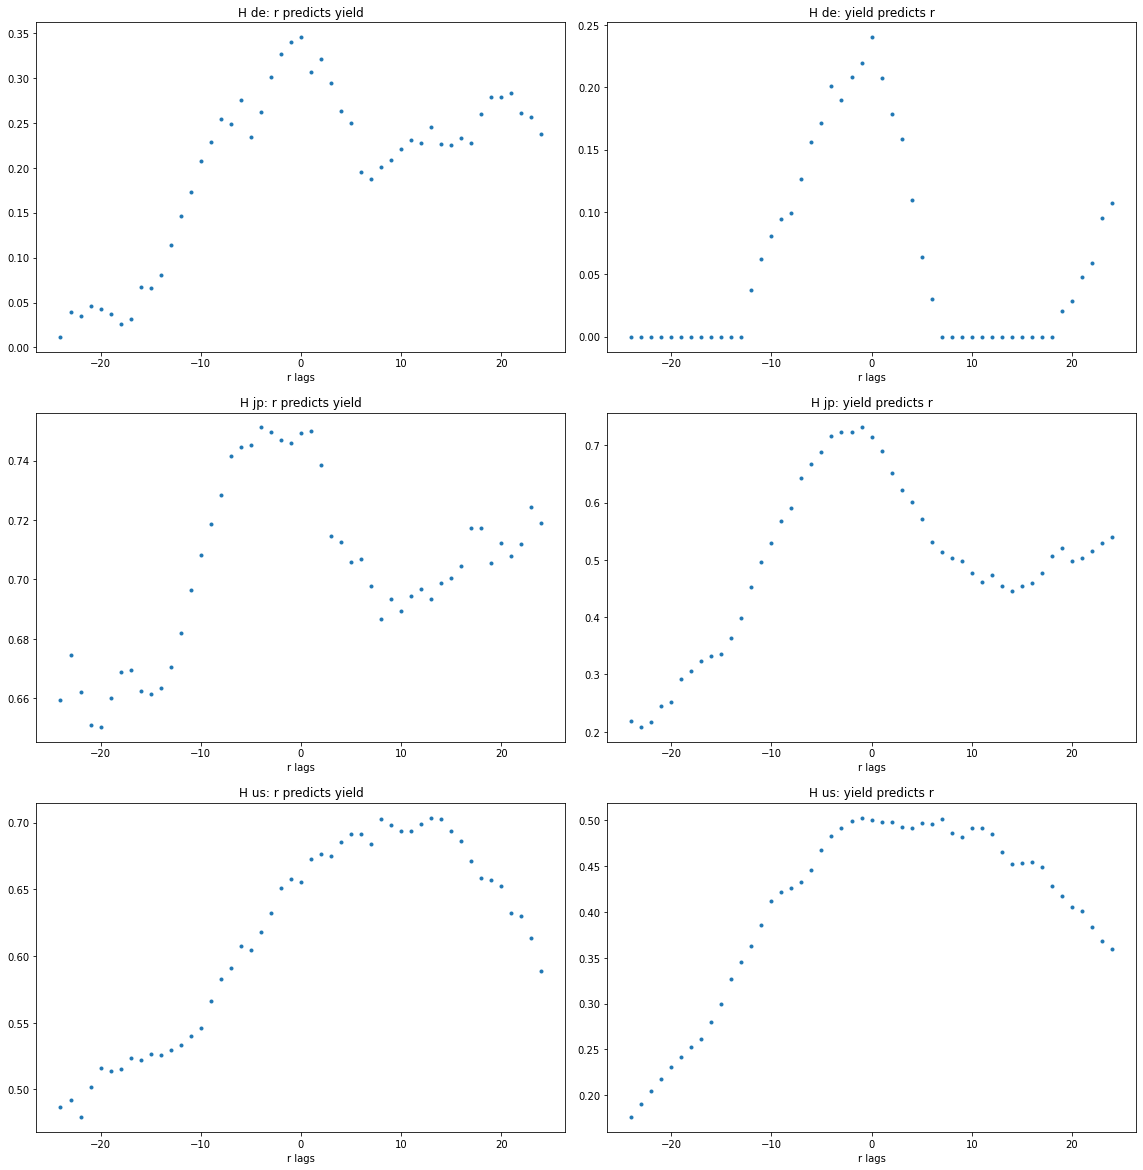

In [144]:
import ppscore as pps

_, ax = plt.subplots(3, 2, figsize=(16, 16))
_.tight_layout(h_pad=4)

save_pscores = {}

for i, c in enumerate(countries):
    
    df1 = df[["{}_r".format(c), "{}_y".format(c)]].dropna()
    deltas = range(-24, 25)
    
    for d in deltas:
        df1["{c}_r_lag_{d}".format(c=c, d=d)] = df1["{}_r".format(c)].shift(d)

    df1 = df1.dropna().drop("{}_r".format(c), axis=1)
    pscores = pps.matrix(df1)
    save_pscores[c] = pscores
    
    ordered_r_pred_y = [
         pscores.loc[(pscores["x"] == "{c}_r_lag_{l}".format(c=c,l=l)) & 
                     (pscores["y"] == "{}_y".format(c))]["ppscore"].values[0]
         for l in deltas
     ]
    
    ax[i, 0].plot(deltas, ordered_r_pred_y, '.')
    ax[i, 0].set(
        title="H {}: r predicts yield".format(c), 
        xlabel="r lags"
                )
    
    ordered_y_pred_r = [
        pscores.loc[(pscores["x"] == "{}_y".format(c)) & 
                    (pscores["y"] == "{c}_r_lag_{l}".format(c=c, l=l))]["ppscore"].values[0]
        for l in deltas
    ]
    
    ax[i, 1].plot(deltas, ordered_y_pred_r, '.')
    ax[i, 1].set(
        title="H {}: yield predicts r".format(c),
        xlabel="r lags"
    )

___
### Clarify Corresponding Causality Convictions
___

In the above plots, I shifted the $r$ timeseries backwards and forwards in time by up to $10t$s and took the PPS scores of the hypotheses below. In a line, the left side column uses $yield$ as the target to be explained and $r$ as the explanatory variable. The right side column of plots are predictive scores for the opposite causality - $r$ dependent, $yield$ independent.

Again, the `df.shift(lag)` moves the dataframe column down by `lag` so we can interpret `.shift(lag)` as pulling the timeseries `lag` steps forward (positive lag) or backward (negative lag) in time...

#### $H_0$ - "Change in interest rate will cause a change in yields"
... So, a person who believes that "$\Delta r$  causes $\Delta yield$" would expect today's $r$ values to say more about a future value of $yield$ than the present. This belief would correspond to an exepctation that positive lags (bringing past values of $r$ forward in time) would speak more about $yield$ than negative ones.

#### 👀
Starting with an eyeball test on the left columns of plots, we see that America's plot is in favour of $H_0$, Japan's rejects it and Germany appears more or less balanced, normal-like. Taking into consideration the range of the scores, Germany's scores suggest that there may not be much going on at all. 

#### $H_1$ - "Change in yield will cause a change in interest rate"
A person who believes that "$\Delta yield$ causes $\Delta r$" would expect today's $yield$ to say something about yesterday's $r$, or equivalently, that today's $r$ will say something about tomorrow's $yield$. This corresponds to an expectation that negative lags (pulling r back in time) would speak more about $yield$ than the positive lags.

#### 👀
This, we see quite clearly in the right side Japanese and German plots, not so for the American plot. So at least superficially, it appears that the Japanese and German series would reject $H_0$ and the American one would not. We also see the magnitude of Germay's scores being of significantly smaller, just like on the left. Notice that America's plot has a waviness to it on the right. 

#### Thoughts, Speculation, Potential Improv on the Method

From inspection of the shapes of the plots, we observe that:

- $H_0$ - Changes of $r$ today will cause a change in $yield$ tomorrow

- $H_1$ - Changes of $yield$ today will cause a change in $r$

It appears that $H_0$ could be rejected by Japan's plot ❌, not rejected by America's plot ⭕️, and indifferent for Germany's plot ❓.

It appears that $H_1$ could be rejected by Japan's plot ⭕️ nor by Germany's plot ⭕️, but by America's plot ❌. 

There are two more observations that we have made:

1. The magnitude differences in PPS

Germany's scores are significantly smaller than those of Japan and America. There's two ways of interpreting this: The first is that Germany's series just don't say much about each other. This is unlikely, and sticking to the constraints of my logic/theory paradigm we should probably err towards the conclusion that Japan's and America's correlations and PPS are suspiciously high. In the case of the correlations, I have already mentioned the spuriousness. The case of PPS may be due to the fact Germany's $yield$ timeseries fluctuates relatively far from the median (horizontal red dashed line) particularly as compared to Japan or America's $yield$ plots. This can result in lower PPS values because PPS is a relativised score where the baseline is that of the naive strategy "guess the median", measured with mean absolute error. So, the more the series adheres to the median, the better the naive strategy should perform relative to the actual model, the lower the typical PPS score for those datasets, I suspect. Perhaps that's something I should check.

$$
PPS = 1-\frac{MAE_{model}}{MAE_{naive}}
$$

2. Waviness in the American plots

Given that we are playing with lags, given the way that the America plot looks, given that it is almost certainly not stationary, the waviness of the positive lags on the $H_1$ plot suggests to me that there's actually a bit of spuriousness, broadly speaking, going on here. Not only in the stationarity sense, but also perhaps that the high positive lags are actually a assocaiting the $n^{th}$ wave of yield with the ${n+1}^{th}$ wave of rates

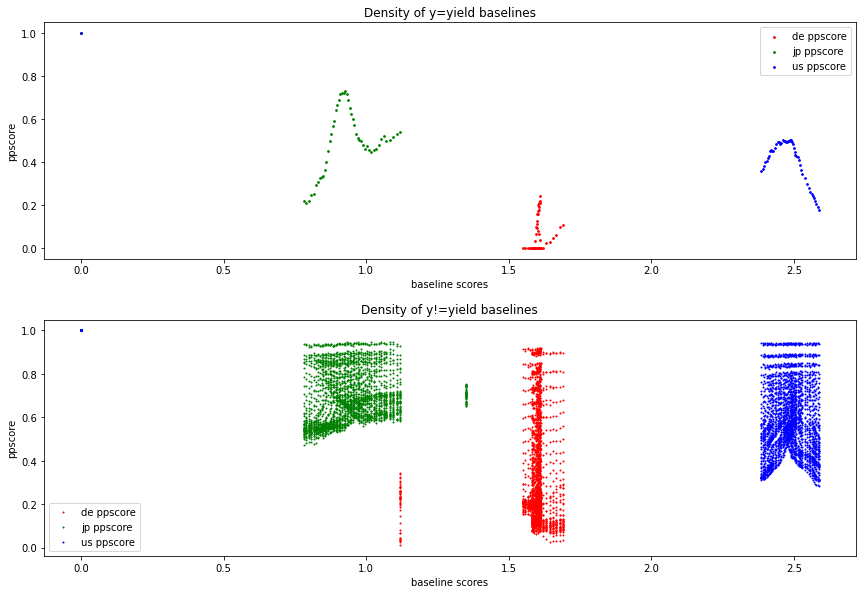

In [212]:
# --- 1. Inspect Baseline

_, ax = plt.subplots(2, figsize=(12, 8))
_.tight_layout(h_pad=4)
col_map = ["r", "g", "b"]

for i, c in enumerate(countries):
    x_is_yield = save_pscores[c].loc[save_pscores[c]["x"] == "{}_y".format(c)]
    x_is_yield.plot(kind="scatter", x="baseline_score", y="ppscore",
                          s=3, c=col_map[i], ax=ax[0], label="{} ppscore".format(c)
                        )
    ax[0].set(title="Density of y=yield baselines", xlabel="baseline scores")
    
    y_is_yield = save_pscores[c].loc[save_pscores[c]["x"] != "{}_y".format(c)]
    y_is_yield.plot(kind="scatter", x="baseline_score", y="ppscore",
                          s=1, c=col_map[i], ax=ax[1], label="{} ppscore".format(c)
                        )
    ax[1].set(title="Density of y!=yield baselines", xlabel="baseline scores")

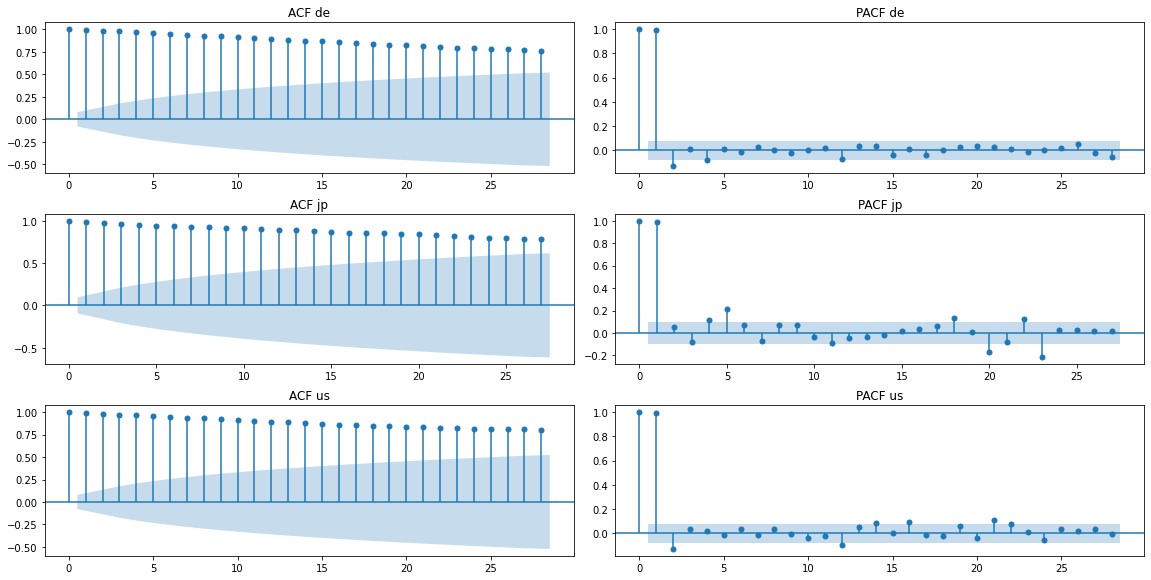

In [141]:
# --- Cursory check for autcorrelation in yields which like, surely.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, ax = plt.subplots(3, 2, figsize=(16, 8))
_.tight_layout(h_pad=2)

for i, c in enumerate(countries):
    plot_acf(df["{}_y".format(c)].dropna(), ax=ax[i, 0])
    plot_pacf(df["{}_y".format(c)].dropna(), ax=ax[i, 1])
    ax[i, 0].set(title="ACF {}".format(c))
    ax[i, 1].set(title="PACF {}".format(c))

Anyone surprised?

I wonder what the rates ACs look like

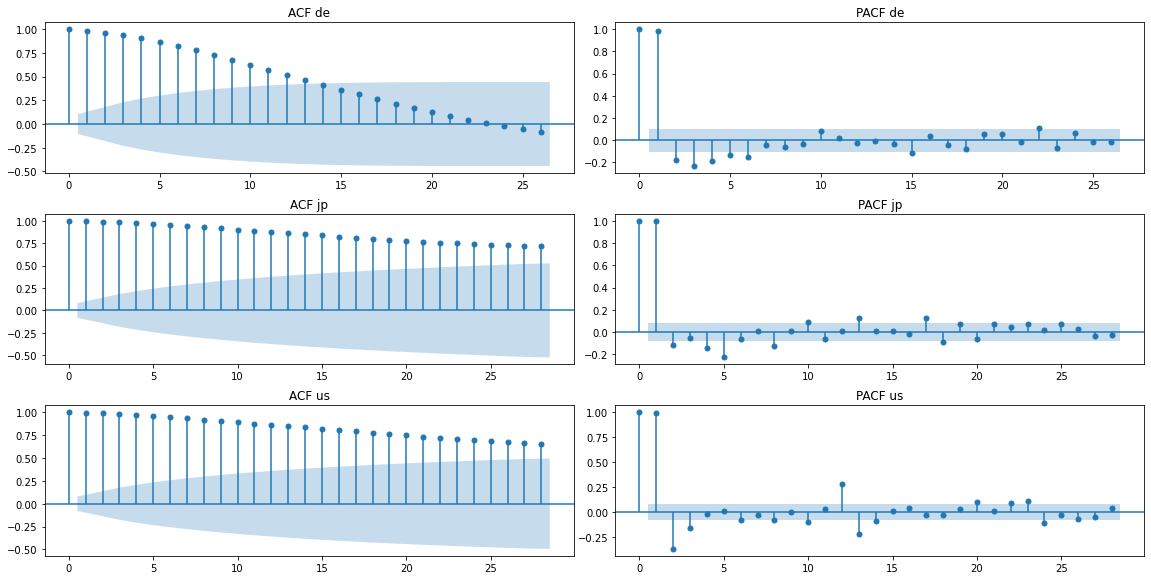

In [140]:
# --- Check for autocorrelation in rates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, ax = plt.subplots(3, 2, figsize=(16, 8))
_.tight_layout(h_pad=2)

for i, c in enumerate(countries):
    plot_acf(df["{}_r".format(c)].dropna(), ax=ax[i, 0])
    plot_pacf(df["{}_r".format(c)].dropna(), ax=ax[i, 1])
    ax[i, 0].set(title="ACF {}".format(c))
    ax[i, 1].set(title="PACF {}".format(c))

Wild.

In [103]:
pscores

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,us_y,us_y,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,us_y,us_r_lag_-10,0.389406,regression,True,mean absolute error,2.513976,1.535019,DecisionTreeRegressor()
2,us_y,us_r_lag_-9,0.398974,regression,True,mean absolute error,2.505939,1.506135,DecisionTreeRegressor()
3,us_y,us_r_lag_-8,0.403507,regression,True,mean absolute error,2.497902,1.489981,DecisionTreeRegressor()
4,us_y,us_r_lag_-7,0.416352,regression,True,mean absolute error,2.489865,1.453204,DecisionTreeRegressor()
...,...,...,...,...,...,...,...,...,...
524,us_r_lag_11,us_r_lag_7,0.792739,regression,True,mean absolute error,2.411286,0.499765,DecisionTreeRegressor()
525,us_r_lag_11,us_r_lag_8,0.836445,regression,True,mean absolute error,2.409171,0.394031,DecisionTreeRegressor()
526,us_r_lag_11,us_r_lag_9,0.882959,regression,True,mean absolute error,2.407479,0.281775,DecisionTreeRegressor()
527,us_r_lag_11,us_r_lag_10,0.937785,regression,True,mean absolute error,2.405787,0.149676,DecisionTreeRegressor()


Nothing unexpected here. Germany shows balanced predictive scores, 

In [ ]:
# --- DATA WRITER

# import csv
# c = 'de'

# with open(path+"raw/10yr_bond_yields_{}_raw.csv".format(c)) as f:
#     content = f.read().splitlines()

# clean = []
# for i, l in enumerate(content):
#     if i == 0:
#         clean.append(l.split(" "))
#     else:
#         line = l.replace("\t", ",")
#         split = line.split(",")
        
#         date = split[0]
#         new_date = dt.datetime.strptime(date, "%b %y")
    
#         clean.append([new_date, split[1]])

# clean
# with open(path+"clean/10yr_bond_yields_{}.csv".format(c), 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(clean)